<a href="https://colab.research.google.com/github/Tarwish2005/-ECG-Arrhythmia-Detection/blob/main/Arrthythmia-Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install wfdb numpy scipy scikit-learn torch torchaudio torchvision matplotlib


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import resample, butter, filtfilt
import numpy as np
import os
import wfdb


#Parameter

In [3]:
VFDB_DIR   = "/content/drive/MyDrive/ECG/VFDB"
CUVTDB_DIR = "/content/drive/MyDrive/ECG/CUVTDB"
ADB_DIR    = "/content/drive/MyDrive/ECG/MITDB"   # (use Arrhythmia DB path if different)
NSTDB_DIR  = "/content/drive/MyDrive/ECG/NSTDB"       # contains 'ma' noise
TARGET_FS  = 250
WIN_SEC    = 5
WIN_SAMPLES = TARGET_FS * WIN_SEC


#Preprocessing


In [4]:
def highpass_filter(signal, fs=250, cutoff=1.0, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

def preprocess_ecg(signal, fs=250, target_fs=250, window_size=5):
    # Resample
    if fs != target_fs:
        signal = resample(signal, int(len(signal) * target_fs / fs))

    # Baseline wander removal
    signal = highpass_filter(signal, fs=target_fs)

    # Mean subtraction + normalization
    signal = signal - np.mean(signal)
    std_val = np.std(signal)
    if std_val > 1e-8:  # Avoid division by very small numbers
        signal = signal / std_val

    # Segment into windows
    segment_length = window_size * target_fs
    n_segments = len(signal) // segment_length

    if n_segments == 0:
        return np.array([])

    segments = []
    for i in range(n_segments):
        segment = signal[i*segment_length:(i+1)*segment_length]
        # Additional check for NaN or inf values
        if not (np.isnan(segment).any() or np.isinf(segment).any()):
            segments.append(segment)

    return np.array(segments)



#DATA

In [7]:
def load_mitdb(db_path):
    X, y = [], []
    if not os.path.exists(db_path):
        print(f"Warning: {db_path} does not exist")
        return X, y

    records = [f.split('.')[0] for f in os.listdir(db_path) if f.endswith('.dat')]
    print(f"Found {len(records)} MITDB records")

    for record in records:
        try:
            rec = wfdb.rdrecord(os.path.join(db_path, record))
            if rec.p_signal is not None and rec.p_signal.shape[1] > 0:
                sig = rec.p_signal[:, 0]  # single channel
                segments = preprocess_ecg(sig, fs=rec.fs)
                if len(segments) > 0:
                    X.extend(segments)
                    y.extend([0] * len(segments))  # Non-VT/VF
        except Exception as e:
            print(f"Error processing {record}: {e}")
            continue

    print(f"MITDB: Loaded {len(X)} segments")
    return X, y

def load_vfdb(db_path):
    X, y = [], []
    if not os.path.exists(db_path):
        print(f"Warning: {db_path} does not exist")
        return X, y

    records = [f.split('.')[0] for f in os.listdir(db_path) if f.endswith('.dat')]
    print(f"Found {len(records)} VFDB records")

    for record in records:
        try:
            rec = wfdb.rdrecord(os.path.join(db_path, record))
            if rec.p_signal is not None and rec.p_signal.shape[1] > 0:
                sig = rec.p_signal[:, 0]
                segments = preprocess_ecg(sig, fs=rec.fs)
                if len(segments) > 0:
                    X.extend(segments)
                    y.extend([1] * len(segments))  # VT/VF
        except Exception as e:
            print(f"Error processing {record}: {e}")
            continue

    print(f"VFDB: Loaded {len(X)} segments")
    return X, y

def load_nstdb(db_path):
    X, y = [], []
    if not os.path.exists(db_path):
        print(f"Warning: {db_path} does not exist")
        return X, y

    records = [f.split('.')[0] for f in os.listdir(db_path) if f.endswith('.dat')]
    print(f"Found {len(records)} NSTDB records")

    for record in records:
        try:
            rec = wfdb.rdrecord(os.path.join(db_path, record))
            if rec.p_signal is not None and rec.p_signal.shape[1] > 0:
                sig = rec.p_signal[:, 0]
                segments = preprocess_ecg(sig, fs=rec.fs)
                if len(segments) > 0:
                    X.extend(segments)
                    y.extend([2] * len(segments))  # Noisy
        except Exception as e:
            print(f"Error processing {record}: {e}")
            continue

    print(f"NSTDB: Loaded {len(X)} segments")
    return X, y

def load_cuvtdb(db_path):
    X, y = [], []
    if not os.path.exists(db_path):
        print(f"Warning: {db_path} does not exist")
        return X, y

    records = [f.split('.')[0] for f in os.listdir(db_path) if f.endswith('.dat')]
    print(f"Found {len(records)} CUVTDB records")

    for record in records:
        try:
            rec = wfdb.rdrecord(os.path.join(db_path, record))
            if rec.p_signal is not None and rec.p_signal.shape[1] > 0:
                sig = rec.p_signal[:, 0]
                segments = preprocess_ecg(sig, fs=rec.fs)
                if len(segments) > 0:
                    X.extend(segments)
                    y.extend([1] * len(segments))  # VF (same class as vfdb)
        except Exception as e:
            print(f"Error processing {record}: {e}")
            continue

    print(f"CUVTDB: Loaded {len(X)} segments")
    return X, y

#Model

In [8]:
class ECG_CNN(nn.Module):
    def __init__(self, input_length=1250, num_classes=3):
        super(ECG_CNN, self).__init__()

        # 5-layer CNN with 3x1 kernels
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(2)

        self.conv4 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm1d(256)
        self.pool4 = nn.MaxPool1d(2)

        self.conv5 = nn.Conv1d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm1d(512)
        self.pool5 = nn.MaxPool1d(2)

        # Calculate flattened size: 1250 -> 625 -> 312 -> 156 -> 78 -> 39
        self.flattened_size = 512 * 39

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Ensure correct input shape
        if len(x.shape) == 2:
            x = x.unsqueeze(1)

        # Convolutional layers
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu(self.bn4(self.conv4(x))))
        x = self.pool5(self.relu(self.bn5(self.conv5(x))))

        # Flatten and FC layers
        x = x.view(x.size(0), -1)
        features = self.relu(self.fc1(x))  # Store for t-SNE
        features = self.dropout1(features)
        x = self.relu(self.fc2(features))
        x = self.dropout2(x)
        output = self.fc3(x)

        return output, features


#Main

Using device: cuda
Loading datasets...
Found 22 VFDB records
VFDB: Loaded 9240 segments
Found 39 CUVTDB records
CUVTDB: Loaded 707 segments
Found 48 MITDB records
MITDB: Loaded 17328 segments
Found 30 NSTDB records
NSTDB: Loaded 10830 segments
Total dataset: (38105, 1250), Classes: (array([0, 1, 2]), array([17328,  9947, 10830]))
Train: 26673, Val: 5716, Test: 5716
Total model parameters: 5,670,659
Starting training...
Epoch [10/100]
Train Loss: 0.0986, Train Acc: 0.9694
Val Loss: 0.1753, Val Acc: 0.9423
Epoch [20/100]
Train Loss: 0.0716, Train Acc: 0.9745
Val Loss: 0.0795, Val Acc: 0.9746
Epoch [30/100]
Train Loss: 0.0623, Train Acc: 0.9750
Val Loss: 0.0748, Val Acc: 0.9760
Epoch [40/100]
Train Loss: 0.0631, Train Acc: 0.9762
Val Loss: 0.0743, Val Acc: 0.9774
Epoch [50/100]
Train Loss: 0.0599, Train Acc: 0.9768
Val Loss: 0.0704, Val Acc: 0.9755
Epoch [60/100]
Train Loss: 0.0610, Train Acc: 0.9767
Val Loss: 0.0824, Val Acc: 0.9753
Epoch [70/100]
Train Loss: 0.0596, Train Acc: 0.9786
Va

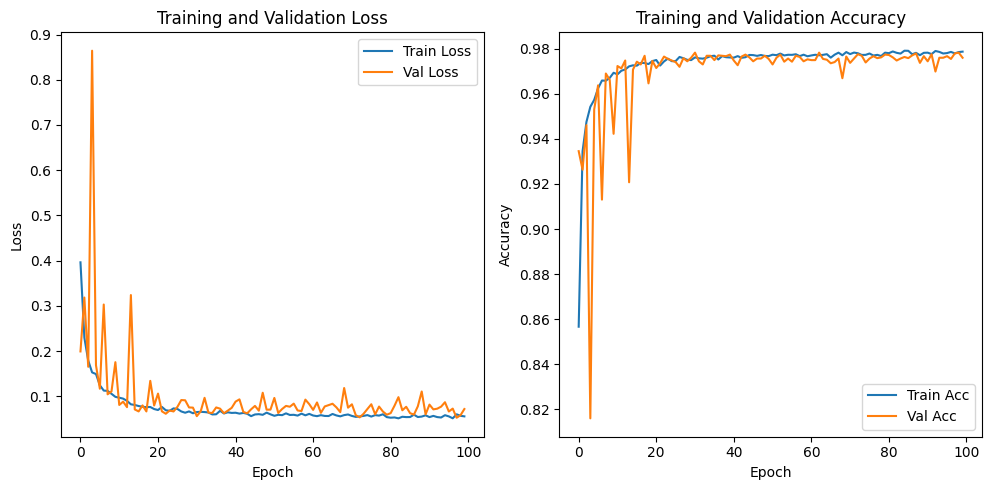

In [15]:
def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load data
    print("Loading datasets...")
    vf_X, vf_y = load_vfdb(VFDB_DIR)
    cu_X, cu_y = load_cuvtdb(CUVTDB_DIR)
    mit_X, mit_y = load_mitdb(ADB_DIR)
    nst_X, nst_y = load_nstdb(NSTDB_DIR)

    # Check if we have data
    if len(vf_X) == 0 and len(cu_X) == 0 and len(mit_X) == 0 and len(nst_X) == 0:
        print("No data loaded! Please check your data paths.")
        return

    # Combine all segments and labels
    all_X = vf_X + cu_X + mit_X + nst_X
    all_y = (vf_y + cu_y + mit_y + nst_y)

    if len(all_X) == 0:
        print("No valid segments found!")
        return

    # Convert to numpy arrays
    X = np.array(all_X)
    y = np.array(all_y)

    print(f"Total dataset: {X.shape}, Classes: {np.unique(y, return_counts=True)}")

    # Check for any remaining NaN or inf values
    if np.isnan(X).any() or np.isinf(X).any():
        print("Warning: NaN or inf values found in data!")
        # Remove problematic samples
        valid_indices = ~(np.isnan(X).any(axis=1) | np.isinf(X).any(axis=1))
        X = X[valid_indices]
        y = y[valid_indices]
        print(f"After cleaning: {X.shape}")


    # Split the data
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

    # Convert to tensors
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    y_train_tensor = torch.LongTensor(y_train).to(device)
    y_val_tensor = torch.LongTensor(y_val).to(device)
    y_test_tensor = torch.LongTensor(y_test).to(device)

    # Create data loaders
    batch_size = 32
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model
    model = ECG_CNN(input_length=X.shape[1], num_classes=len(np.unique(y))).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total model parameters: {total_params:,}")

    # Training loop
    epochs = 100
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    print("Starting training...")
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss, train_correct = 0, 0

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs, _ = model(batch_X)

            # Check for NaN in outputs
            if torch.isnan(outputs).any():
                print(f"NaN detected in outputs at epoch {epoch+1}")
                break

            loss = criterion(outputs, batch_y);

            # Check for NaN in loss
            if torch.isnan(loss):
                print(f"NaN detected in loss at epoch {epoch+1}")
                break


            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)


            optimizer.step()

            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == batch_y).sum().item()

        # Validation phase
        model.eval()
        val_loss, val_correct = 0, 0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs, _ = model(batch_X)
                loss = criterion(outputs, batch_y)

                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == batch_y).sum().item()


        # Calculate metrics
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_acc = train_correct / len(train_dataset)
        val_acc = val_correct / len(val_dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)


        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}]')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    print("Training completed!")

    # Plotting loss and accuracy
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()